<a href="https://colab.research.google.com/github/wqw547243068/school-of-ai-beijing/blob/master/code/lecture_1/fastai_1_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FastAI-深度学习实战-宠物分类
![soai](https://github.com/wqw547243068/school-of-ai-beijing/raw/master/other/SoAI_logo_full.png)
- 【2019-04-29】王奇文，wqw547243068@163.com，[School of AI-Beijing](https://wqw547243068.github.io/school-of-ai-beijing/)


## 第一课 宠物图像分类 Lesson 1-What's your pets ?

- 内容：从零开始，完成图像分类任务，并达到世界领先水平
- 数据集：[Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/)是一个宠物图像数据集，包含12种猫和25种狗,每种宠物200张左右宠物图片，并同时包含宠物轮廓标注信息.共753M
   - ![](http://dataju.cn/Dataju/static/wangEditorImageFolder/7514abd1-4ce3-43af-8419-560987a1d593.jpg)
   - ![](http://dataju.cn/Dataju/static/wangEditorImageFolder/e96b81cc-82f4-4f7e-a44e-2a754a5d3d14.JPG)
   - ![](http://dataju.cn/Dataju/static/wangEditorImageFolder/b4f6ca11-187d-47f9-81ab-1dd06e0f56d0.JPG)
- 任务：区分所有物种，2分类、37分类
   - ![](http://dataju.cn/Dataju/static/wangEditorImageFolder/bf46bb83-f151-4c50-9a0a-d375e6d597ed.jpg)
- 效果：2012年，[O. M. Parkhi et al](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf).论文里用了一个复杂模型，先区分图像，再分清头和身体，费了好大劲，最后取得成绩是：分类准确率59.21%
- 作为刚入门的新人，我们能做到什么程度呢？拭目以待！

## 环境准备
- 按照指定格式准备目录结构
   - 在/root目录下创建.torch和.fastai目录，里面分别包含models和data子目录
   - 简历软连接，指向/content
- curl命令从远程下载bash脚本,，并通过管道(|)命令执行，内容是：
```bash
#!/bin/bash
# 主要功能：fastai本地环境部署
if [ ! -e /content/models ]; then
        mkdir -p /root/.torch/models
        mkdir -p /root/.fastai/data
        ln -s /root/.torch/models /content
        ln -s /root/.fastai/data /content
        rm -rf /content/sample_data/
fi
```

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


### kaggle环境准备
- kaggle的云环境目录结构不同于colab
- /kaggle底下有如下目录：
   - config：配置信息，默认只有jupyter的配置文件jupyter.json
   - input：数据集存放位置（注意：尽量去dataset区域寻找数据集，不要自己上传）
      - 比如：点页面右上角“Add Dataset”，搜索oxfordiiit-pet-dataset，添加到自己的空间
      - 查看是否添加成功，执行以下命令：
```shell
      !ls /kaggle/input/the-oxfordiiit-pet-dataset
```
   - lib：库，不用管
   - working：默认工作目录，写操作限制在这个目录下
- 注意：
   - <font color='red'>请开启右下角Settings区域里的internet（联网下载数据）+GPU选项（训练加速）</font>
   - 请开启右下角Settings区域里的internet（联网下载数据）+GPU选项（训练加速）

### Google Drive
- 如果数据保存在谷歌云上，需要挂载

In [0]:
from google.colab import drive
# 将google硬盘挂载在/comtent/drive/目录上面
drive.mount('/content/drive/') 
# 点击提示的链接，将认证码输入并按enter

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
ls /content/drive/My\ Drive

 20160200-college-de-france/
'Colab Notebooks'/
'Copy of How neural networks work.gslides'
'DeepBayes2018 presentations'/
'deep learning'/
'How neural networks work.gslides'
'Idle SMS Recall Analysis.gsheet'
 ijcai_ecai_tutorial.pdf
 PyTorchZeroToAll/
'School of AI'/
'SMS 测试.gsheet'
 SoAI/
 Tantan/
 tensorflow/
'Untitled document.gdoc'
'Untitled drawing.gdraw'
'已从 Google 笔记本导入 - My first notebook.gdoc'
'已从 Google 笔记本导入 - Notebook 1.gdoc'
 手机测试文档.docx


### 其他
- 可视化：绘图工具嵌入jupyter页面
- 自动刷新功能

- 以下3行代码是每个jupyter笔记都需要添加的，作用是：
   - 确保调用的库自动更新——autoreload
   - 加载画图程序，直接嵌入笔记本——matplotlib

In [0]:
%reload_ext autoreload
%autoreload 2 # 每隔2s自动刷新库
%matplotlib inline # 开启matplotlib嵌入功能，直接显示在笔记内

## fastai包导入
- fastai是在pytorch 1.0基础上构建的深度学习工具包
- 特点：开发速度快，直接使用最先进的模型

In [0]:
from fastai.vision import * # 导入所有子包
from fastai.metrics import error_rate # 评估函数：错误率

### fastai模块
- fastai在pytorch上高度封装
   - fastai是一种超级简洁的深度学习工具，代码上甚至比Keras还要简洁。
   - 底层是pytorch，能够提供高速的处理性能
- 模块架构
   - ![](https://image.oldpan.me/module_overview.png)
- 常用方法：从左到右分别是核心代码、训练代码和应用代码
- ![](https://docs.fast.ai/imgs/dependencies.svg)
- 参考：[使用fastai进行图像分类之120种小狗](https://www.jianshu.com/p/ab35ed21df87)

## GPU验证

- ① NVIDIA自带
    - NVIDIA自带的驱动检测方法，能看到GPU的配置
        - 可以看到colab的GPU是Tesla T4，显存15G，强于上一版本K80 

In [0]:
!nvidia-smi

Wed May  1 03:24:04 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    31W /  70W |   1323MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

- ② GPU监控工具-[gpustat](https://www.ctolib.com/wookayin-gpustat.html)
    - 仅适用于N卡（NVIDIA ），A卡不行（AMD）
    - 效果示例：![](https://github.com/wookayin/gpustat/raw/master/screenshot.png)

In [0]:
#!pip install gpustat
!gpustat -cp

  Stored in directory: /root/.cache/pip/wheels/2e/7a/86/ae2c167876a53a7519aed8ae8543455f50825384268e1d7245
Successfully built gpustat
54b5f69d9cf8  Wed May  1 03:30:04 2019
[0] Tesla T4         | 71'C,   0 % |  1323 / 15079 MB |


- ③ Pytorch的GPU测试方法

In [0]:
torch.cuda.is_available()

True

In [0]:
torch.backends.cudnn.enabled

True

- ④ Tensorflow的GPU测试代码

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## 设置batch_size
- bs是每个喂给模型的样本量，数字越大，越吃内存
- 如果运行过程中，内存溢出，请将bs值调小
- bs数值符合2^n，为什么？
   - 计算机底层设计有关，电脑的CPU/GPU处理的都是二进制，不管32位还是64位，为了最大限度利用起来，需要设置成2的幂级数形式
   - <font color='blue'>计算机底层设计有关，电脑的CPU/GPU处理的都是二进制，不管32位还是64位，为了最大限度利用起来，需要设置成2的幂级数形式</font>

In [0]:
# bs = 64
# bs = 16
bs = 8

## 数据准备
- 下载图像数据集到本地
- 数据拆分：特征+标签

In [0]:
# URLs包含了很多有用的数据集地址，如mnist
#URLs.MNIST
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

In [0]:
# 从亚马逊云上下载数据，宠物数据集地址：https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'
# 如果无法访问，直接去牛津大学数据集地址：http://www.robots.ox.ac.uk/~vgg/data/pets/
PET_URL = 'http://www.robots.ox.ac.uk/~vgg/data/pets' 
path = untar_data(URLs.PETS) # 解压缩
#path = untar_data(PET_URL)
path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

- path包包含了大量linux本地操作命令，如：ls、mkdir等

In [0]:
path.ls() # 查看当前目录下的文件
#!pwd # 除了调用path子包，还可以加!直接调用linux命令

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

## 数据读取
- 数据集分成图片及标签，分别对应images和annotation目录
- 此处可以通过linux命令计算图片数目
- 用python的PIL和matplotlib显示图片内容

In [0]:
path_anno = path/'annotations'
path_img = path/'images'
#!ls $path_img # 显示目录下的图片文件: beagle_194.jpg和beagle_194.mat
!ls $path_img | wc -l # 显示文件数目7393
!ls $path_img | awk -F'.' '{print $2}'|sort|uniq -c
!echo "显示annotation目录内容："
!ls $path_anno

7393
      1 
显示annotation目录内容：
list.txt  README  test.txt  trainval.txt  trimaps  xmls


In [0]:
!wc -l $path_anno/*

   7355 /root/.fastai/data/oxford-iiit-pet/annotations/list.txt
     45 /root/.fastai/data/oxford-iiit-pet/annotations/README
   3669 /root/.fastai/data/oxford-iiit-pet/annotations/test.txt
   3680 /root/.fastai/data/oxford-iiit-pet/annotations/trainval.txt
wc: /root/.fastai/data/oxford-iiit-pet/annotations/trimaps: Is a directory
      0 /root/.fastai/data/oxford-iiit-pet/annotations/trimaps
wc: /root/.fastai/data/oxford-iiit-pet/annotations/xmls: Is a directory
      0 /root/.fastai/data/oxford-iiit-pet/annotations/xmls
  14749 total


In [0]:
!head $path_anno/list.txt

#Image CLASS-ID SPECIES BREED ID
#ID: 1:37 Class ids
#SPECIES: 1:Cat 2:Dog
#BREED ID: 1-25:Cat 1:12:Dog
#All images with 1st letter as captial are cat images
#images with small first letter are dog images
Abyssinian_100 1 1 1
Abyssinian_101 1 1 1
Abyssinian_102 1 1 1
Abyssinian_103 1 1 1


In [0]:
!head $path_anno/trainval.txt
!head $path_anno/test.txt

Abyssinian_100 1 1 1
Abyssinian_101 1 1 1
Abyssinian_102 1 1 1
Abyssinian_103 1 1 1
Abyssinian_104 1 1 1
Abyssinian_105 1 1 1
Abyssinian_106 1 1 1
Abyssinian_107 1 1 1
Abyssinian_108 1 1 1
Abyssinian_109 1 1 1
Abyssinian_201 1 1 1
Abyssinian_202 1 1 1
Abyssinian_204 1 1 1
Abyssinian_205 1 1 1
Abyssinian_206 1 1 1
Abyssinian_207 1 1 1
Abyssinian_20 1 1 1
Abyssinian_210 1 1 1
Abyssinian_212 1 1 1
Abyssinian_213 1 1 1


- 文件说明
   - list.txt——所有数据集文件名列表
   - trainval.txt——训练集、验证集文件名列表
   - test.txt——测试集文件名列表
   - list = trainval + test
- label文件trainval.txt说明：

|Name-图片文件名|Class ID-类目ID|SPECIES-物种ID|BREED ID-物种类目ID|
|---|---|---|---|
|Abyssinian_100|1|1|1|
|Abyssinian_101|1|1|1|
|...|...|...|...|
|Siamese_157|33|1|11|
|Siamese_158|33|1|11|
|yorkshire_terrier_189|37|2|25|
|yorkshire_terrier_18|37|2|25|
|yorkshire_terrier_190|37|2|25|

备注：
- Class ID 是对应于pet_label_map.pbtxt的ID值
- SPECIES是总分类:1:猫 2:狗
- BREED ID :在分类下面的子分类序号,对于总分类1猫其序号为1-25;对于总分类2狗，其序号为1-12。
- [采用Oxford-IIIT Pets数据训练Object-Detect](https://www.jianshu.com/p/3b472539b88a)


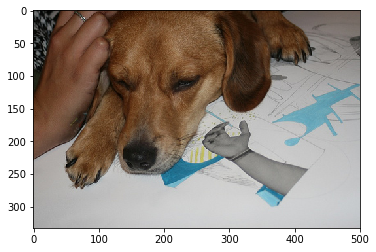

In [0]:
#!ls $path_img | head
from matplotlib import pyplot as plt
from PIL import Image

img_file = '%s/beagle_194.jpg'%(path_img) # 随便选一张图片
plt.imshow(Image.open(img_file))

- 通过fastai内置方法读取图像，显示5张

In [0]:
fnames = get_image_files(path_img) # 将所有文件列表读入列表fnames
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_184.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Persian_56.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/leonberger_136.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_62.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_127.jpg')]

In [0]:
np.random.seed(2) # 固定随机种子，保证每次随机数一样！
pat = r'/([^/]+)_\d+.jpg$' # 正则表达式，只提取jpg文件，剔除mat文件

In [3]:
import numpy as np

np.random.seed(0) # 开启时，每次随机数都一样
np.random.rand(1)

array([0.5488135])

### 思考
- 监督学习的特征（feature，输入）是有了，37种哺乳动物的图片，可是标签（label，输出）在哪儿？

- 答案：label在图片名字中，这就是正则表达式的功劳！

### 继续看看猫猫狗狗
- data是fastai内置的数据类型，包含多种方法

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

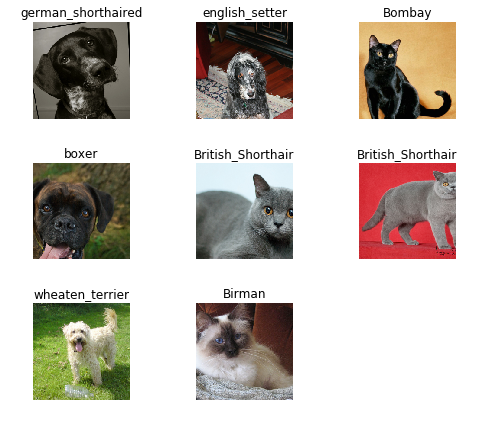

In [0]:
data.show_batch(rows=8, figsize=(7,6)) # 通过fastai内置方法显示图片

In [0]:
print(data.classes) 
len(data.classes), data.c # 显示不同种类的猫狗数目

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## 建立神经网络模型
- 此处直接通过一条命令创建传说中的resnet34 <font color='red'>resnet34</font>
- 注意：解决问题前，一定要先充分理解数据！

### 听说你不懂CNN？
- 大佬叫你过去听课：[Yann LeCun连发三弹：人人都懂的深度学习基本原理](https://www.leiphone.com/news/201612/Sjkmer9Kto5ILxFk.html?utm_source=itdadao&utm_medium=referral)
- mnist手写数字识别[3D交互体验](http://scs.ryerson.ca/~aharley/vis/conv/)
- ![cnn](https://static.leiphone.com/uploads/new/article/740_740/201612/58415ac7a72c6.gif)

### 从易到难-MNIST
- 手写数据集分类
- 几行代码就实现了0.97%的准确率！

In [0]:
from fastai.vision import * # 导入所有子包
from fastai.metrics import error_rate # 评估函数：错误率

path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
46827520it [00:00, 125889554.49it/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.140596,0.082088,0.973013,00:08


In [0]:
learn.metrics

[<function fastai.metrics.accuracy>]

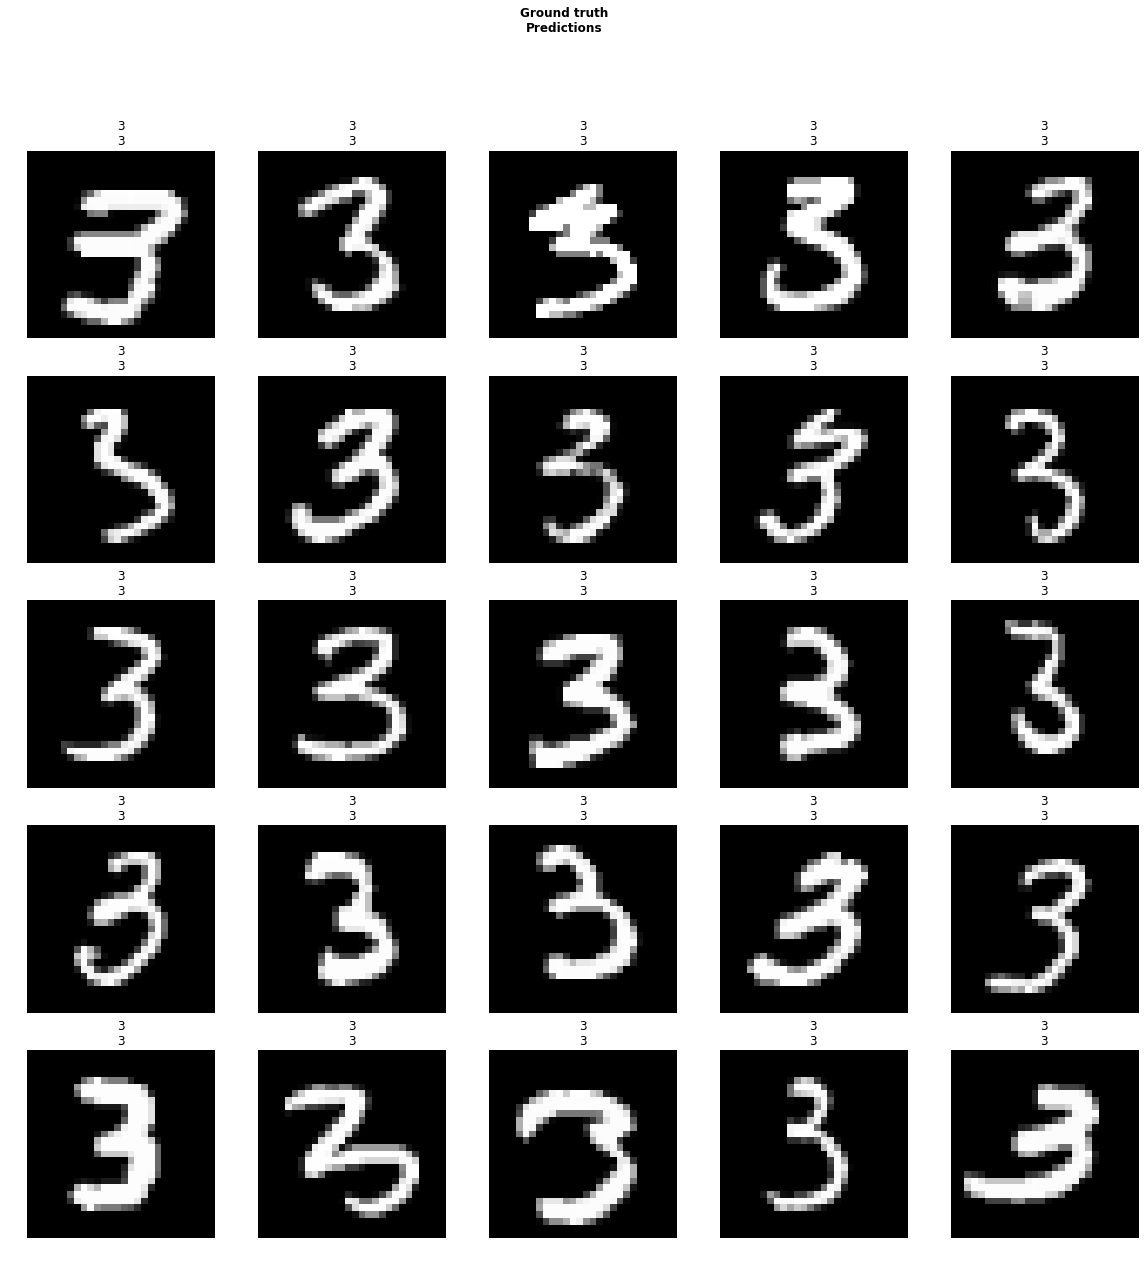

In [0]:
learn.show_results()

### 宠物分类
- 尝试玩mnsit，回到主题

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 102671333.18it/s]


- 查看resnet网络结构：很复杂。。。
- ![resnet](http://file.elecfans.com/web1/M00/55/F4/o4YBAFs25PqAFKqxAADawrrlpcQ013.png)
- learn是什么样的对象？
   - learn有哪些可用方法？——learn.后按Tab键-<font color='red'>Tab键</font>，会自动提示可用方法
   - learn.fit_one_cycle是什么意思？——后面加问号<font color='red'>?</font>执行，就能看到方法介绍

In [0]:
# 显示方法含义，后面加问号！结果：Fit a model following the 1cycle policy. 单周期策略的模型训练方法
learn.fit_one_cycle?
learn.model # 显示网络结构

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

## 模型训练
- 训练时，可能陷入局部极小值，而非全局极小值
   - ![](https://pic4.zhimg.com/80/v2-87dc5223e5d868b55aaef3750d7fd0b7_hd.jpg)
- 单周期策略的学习率方法,[fit_one_cycle](https://docs.fast.ai/training.html)
   - ![](https://cdn-images-1.medium.com/max/1600/1*fI0l_gIezdHLFlZpJ2s8iA.png)
- 差分学习率：训练时变换网络层比提高网络深度更重要
   - ![](https://pic3.zhimg.com/80/v2-cf95f4bfbdd947f5a985ced305d9139e_hd.jpg)
- 参考：[称霸Kaggle的十大深度学习技巧](https://zhuanlan.zhihu.com/p/41379279)
- 激动人心的时刻到了！训练神经网络模型！

In [0]:
learn.fit_one_cycle(4) # 训练4个epoch（周期）

epoch,train_loss,valid_loss,error_rate,time
0,0.888307,0.403361,0.129229,02:01
1,0.796944,0.339743,0.099459,02:02
2,0.616858,0.263689,0.080514,02:02
3,0.471726,0.245238,0.078484,02:02


In [0]:
learn.

## 模型保存
- save方法用于保存模型

In [0]:
learn.save('stage-1')
#learn.save('/kaggle/working/stage-1') # kaggle专用：将模型保存在工作目录下，commit后可下载

## 效果分析
- 哪些样本最差，长什么样子

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses() ## 看看那些样本最差
len(data.valid_ds)==len(losses)==len(idxs)

True

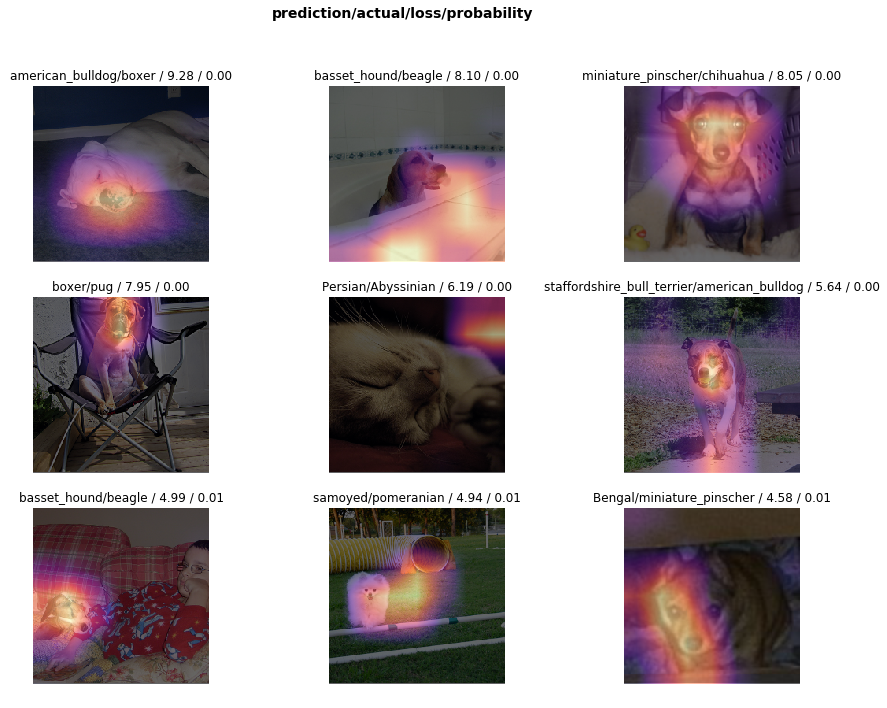

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

- 显示某方法的说明，等同于加问号

In [0]:
!ls $path_img/pomeranian_47.jpg

/root/.fastai/data/oxford-iiit-pet/images/pomeranian_47.jpg


In [0]:
data.data.label_list

In [0]:
doc(interp.plot_top_losses)

## 模型评估
- 由于是分类问题，这里采用模糊矩阵
- 如果是回归问题，需要采样别的指标，如MAE,MSE等，详情参考官方[Metrics](https://docs.fast.ai/metrics.html)

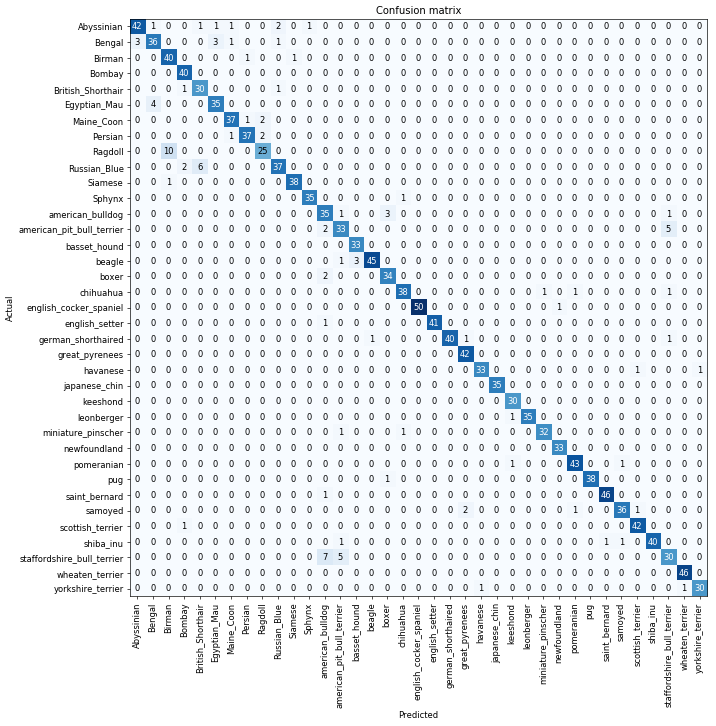

In [0]:
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

### 模糊矩阵
- 横轴是所有N个类目，对应groud truth真值；纵轴也是N个，表示预测的类目——对称矩阵
- 如果大部分样本越集中在对称轴上（颜色深），效果越好

In [0]:
interp.most_confused(min_val=2) #最难分的是哪些样本

[('Ragdoll', 'Birman', 10),
 ('staffordshire_bull_terrier', 'american_bulldog', 7),
 ('Russian_Blue', 'British_Shorthair', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Bengal', 'Abyssinian', 3),
 ('Bengal', 'Egyptian_Mau', 3),
 ('american_bulldog', 'boxer', 3),
 ('beagle', 'basset_hound', 3),
 ('Abyssinian', 'Russian_Blue', 2),
 ('Maine_Coon', 'Ragdoll', 2),
 ('Persian', 'Ragdoll', 2),
 ('Russian_Blue', 'Bombay', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('boxer', 'american_bulldog', 2),
 ('samoyed', 'great_pyrenees', 2)]

In [0]:
learn.predict()

TypeError: ignored

## 效果迭代
- 模型训练完成后，默认“冻结”freeze
- 如果需要继续训练，先执行“解冻”unfreeze
- 注意：模型效果是错误率13.3%，也就是正确率86.7%！

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.982449,0.445620,0.133288,02:27


In [0]:
learn.load('stage-1');

## 模型调优
- 神经网络超参很多：网络结构、层数、激活函数、bs、学习率等

### 方法一：学习率
- 如果精力有限，就先调最重要的参数——学习率
- 找到好的学习率后，更新到模型，重新训练

In [0]:
learn.lr_find() # 查找最合适的学习率

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


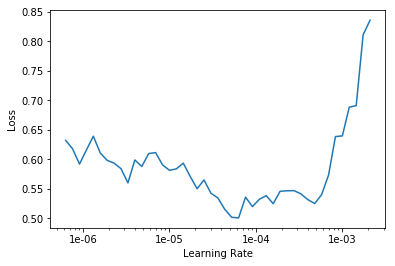

In [0]:
learn.recorder.plot() # 分析学习率取什么值最好

In [0]:
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4)) # 更新学习率，重新训练

epoch,train_loss,valid_loss,error_rate,time
0,0.435095,0.238926,0.072395,02:26


### 方法二：更改batch_size

In [0]:
learn.save('stage-2')

In [0]:
#data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),size=299, bs=bs//2).normalize(imagenet_stats)

### 方法三：升级模型
- resnet34→resnet50

In [0]:
#learn = create_cnn(data, models.resnet34, metrics=error_rate)
learn = create_cnn(data, models.resnet50, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:04, 25443451.98it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


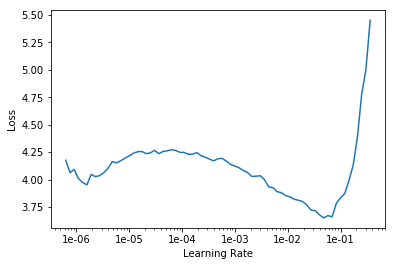

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.061286,0.276833,0.086604,04:34


In [0]:
learn.save('stage-1-50')

In [0]:
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.745421,0.249251,0.081191,06:07


In [0]:
learn.save('stage-2-50')

## 思考
- 错误率8.1%，也就是正确率91.9%！高于之前的87%
   - 问题：为什么resnet50优于resnet34？
   - 答案：50层的网络比34层复杂，学习能力更强
- 是不是感觉自己很厉害？切，还不是因为深度神经网络！不信看看历史效果![history](https://ss3.bdstatic.com/70cFv8Sh_Q1YnxGkpoWK1HF6hhy/it/u=3736212811,2148870726&fm=26&gp=0.jpg)
   - [深度学习在计算机视觉领域的前沿进展](https://zhuanlan.zhihu.com/p/24699780)
- 牛顿说了，不是我厉害，而是因为站在了巨人的肩膀上！
- PS：还能继续提升吗？——靠你自己了！加油

![addoil](https://s.yimg.com/ny/api/res/1.2/unSXX6m.mrIFWzJ99gcgSQ--~A/YXBwaWQ9aGlnaGxhbmRlcjtzbT0xO3c9NTAw/http://media.zenfs.com/zh-Hant-HK/homerun/yahoocontent.nmg.com.hk/fe7573cef8ec3f73c95d0b0b54f186b7)

## 附录

[![soai](https://github.com/wqw547243068/school-of-ai-beijing/raw/master/other/first_lecture.jpg)](https://wqw547243068.github.io/school-of-ai-beijing/)